In [1]:
import os
import glob
import time
import pickle
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 12,12

from Queue import Queue
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle

# Vehicle Detection and Tracking

Author: Lyuboslav Petrov


## Summary
Self driving car applications require the precise detection and tracking of the positions of participants in the traffic, including pedestrians, cyclists, cars and trucks. In this excercise the position of cars in front of a moving vehicle are detected by usage of a monocular video stream of a front mounted camera. Using a sliding window approach, individual frames are scanned on several scales and each is fed through a pre-trained SVM binary classifier. Centroids of positive detections are clustered together using DBSCAN. A moving average approach through a series of frames is implemented for a final filtering technique. The resulting pipe works well on the project video supplied, however it does not do well with the challange videos.


## Data Inspection

The data used for training the classifier originates from public benchmarks such as the [Kitti Dataset](http://www.cvlibs.net/datasets/kitti/eval_tracking.php), the [GTI Dataset](https://www.gti.ssr.upm.es/data/Vehicle_database.html) and the [Udacity Dataset](https://github.com/udacity/self-driving-car/tree/master/annotations). In total, the vehicle and non-vehicle samples amounted to approximately 20,000 and 40,000 respectively. The imbalance in the dataseet was seen in the process to be benefitial for the success of the classifier. All images were scaled to 64x64 pixels.

In [2]:
def get_box_area(box):
    """Computes the area of a rectangle
    """
    (x0,y0),(x1,y1) = box
    w,h = x1-x0,y1-y0
    area = w * h
    return area

def clean_up_csv(path_to_csv):
    """Reads-in and cleans up csv file
    
    Parameters
    ----------
    path_to_csv : str
        Path to csv file.
        
    Returns
    -------
    df: pandas dataframe
        Cleaned up and ordered dataframe object
    """
    df = pd.read_csv('object-dataset/labels.csv', header=None)
    
    table = []
    for i in range(len(df[0])):
        row  = df[0][i].split()
        fname = row[0]
        x1,y1,x2,y2 = int(row[1]),int(row[2]),int(row[3]),int(row[4])
        occluded = int(row[5])
        label = row[6].replace('"','')
        table.append([fname, ((x1,y1),(x2,y2)),occluded,label])
        
    df = pd.DataFrame(table,columns=['frame', 'box', 'occluded', 'label'])
    return df

def gen_car_data(path, df, num, min_area=128*128, cspace='bgr'):
    """Car data generator
    
    Generates random car images from the udacity dataset
    
    Parameters
    ----------
    path : string
        Path to extracted udacity data set directory
    df : dataframe object
        A cleaned up dataframe
    num : int
        Number of images to generate
    min_area : int
        Minimum car size in images
        
    Returns
    -------
    output : ndarray
        A list of len `num` with car images
    """
    while True:
        output = []
        while len(output) < num:
            indx = np.random.randint(0,len(df),1)[0]
            frame = df.iloc[indx].frame
            cars_in_image = df[df.frame == frame]
            bboxes = [box for box in cars_in_image.box]
            if len(bboxes) < 1:
                continue
            good_boxes = [box for box in bboxes if get_box_area(box) >= min_area]
            if len(good_boxes) > 0:
                fpath = os.path.join(path, frame)
                img = cv2.imread(fpath)
                if cspace == 'rgb':
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                for box in good_boxes:
                    (x0,y0),(x1,y1) = box
                    resized = cv2.resize(img[y0:y1,x0:x1], (64,64))
                    output.append(resized)
        yield output[:num]
        
def gen_non_car_data(path, df, num, cspace='bgr'):
    """Non-Car data generator
    
    Generates random non-car images from the udacity dataset using
    predefined/hardcoded box locations
    
    Parameters
    ----------
    path : string
        Path to extracted udacity data set directory
    df : dataframe object
        A cleaned up dataframe
    num : int
        Number of images to generate
        
    Returns
    -------
    output : ndarray
        A list of len `num` with non-car images
    """
    while True:
        output = []
        while len(output) <= num:
            indx = np.random.randint(0,len(df), 1)[0]
            frame = df.iloc[indx].frame
            img = cv2.imread(os.path.join(path, frame))
            if cspace == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            boxes = np.array([
                ((200,  200), (400,  400)),
                ((400, 400),  (600, 600)),
                ((600, 700),  (800, 900)),
                ((800, 900),  (1000, 1100)),
                ((1000, 700),  (1200, 900)),
            ], np.int)
            for box in boxes:
                (x0,y0),(x1,y1) = box
                resized = cv2.resize(img[y0:y1,x0:x1], (64,64))
                output.append(resized)
        yield output
        
def gen_from_file_system(paths, num, cspace='bgr'):
    """Car data generator (for Kitti and GTI data)
    
    Generates random car images from the Kitti and GTI datasets
    
    Parameters
    ----------
    path : string
        Path to extracted udacity data set directory
    num : int
        Number of images to generate
        
    Returns
    -------
    output : ndarray
        A list of len `num` with car images
    """
    while True:
        output = []
        while len(output) < num:
            indx = np.random.randint(1, len(paths), 1)[0]
            path = paths[indx]
            img = cv2.imread(path)
            if cspace == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is not None:
                output.append(img)
        yield output

def gen_full_img_data(path, df, num):
    while True:
        output = []
        while len(output) < num:
            indx = np.random.randint(0,len(df),1)[0]
            frame = df.iloc[indx].frame
            fpath = os.path.join(path, frame)
            output.append(img)
        yield output[:num]

In [3]:
df = clean_up_csv('object-dataset/labels.csv')
pedestrians = df[df.label=='pedestrian'].reset_index().drop('index',1)
cars = df[df.label=='car'].reset_index().drop('index',1)
trucks = df[df.label=='truck'].reset_index().drop('index',1)
occluded = cars[cars.occluded == 1].reset_index().drop('index', 1)
noccluded = cars[cars.occluded == 0].reset_index().drop('index', 1)

# WriteUp Data
non_car_gen = gen_non_car_data('object-dataset/', pedestrians, 5, cspace='rgb')
occluded_cars_gen = gen_car_data('object-dataset/', occluded, 5, cspace='rgb')
noccluded_cars_gen = gen_car_data('object-dataset/', noccluded, 5, cspace='rgb')
kitti_path = glob.glob('vehicles/KITTI_extracted/*.png')
gti_path = kitti_path = glob.glob('vehicles/GTI*/*.png')
kitti_gen = gen_from_file_system(kitti_path,5, cspace='rgb')
gti_gen = gen_from_file_system(gti_path,5, cspace='rgb')

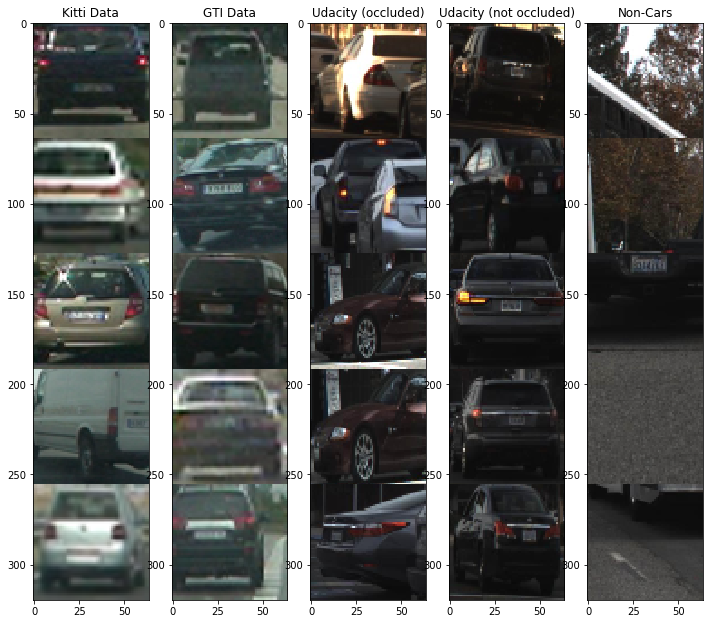

In [4]:
plt.subplot2grid((1,5), (0,0))
plt.imshow(np.vstack(kitti_gen.next()))
plt.title('Kitti Data')

plt.subplot2grid((1,5), (0,1))
plt.imshow(np.vstack(gti_gen.next()))
plt.title('GTI Data')

plt.subplot2grid((1,5), (0,2))
plt.imshow(np.vstack(occluded_cars_gen.next()))
plt.title('Udacity (occluded)')

plt.subplot2grid((1,5), (0,3))
plt.imshow(np.vstack(noccluded_cars_gen.next()))
plt.title('Udacity (not occluded)')

plt.subplot2grid((1,5), (0,4))
plt.imshow(np.vstack(non_car_gen.next()[0:5]))
plt.title('Non-Cars')


## Feature extraction

The features tested upon included a color/histogram based features, spatial features and [HOG](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) features. Throughout lengthy testing iterations it was found that solely the HOG features from the U-V channels of the YUV colorspace encode sufficiently well the information. The reasoning is that the two chrominance channels (U&V) are less dependent on illumination and shadow effects. The spatial and color based features were discarded.

In [5]:
def get_hog_features(img, orient=8, pixels_per_cell=16, cell_per_block=4, vis=False, feature_vector=True):
    """Computes the HOG features of an image
    
    Parameters
    ----------
    img : ndarray
        Input single/multi channel image
    orient : int
        HOG orientation resolution
    pixles_per_cell : int
        Number of pixels within one HOG cell
    cell_per_block : int
        Number of cells within a block for local effect filtering
    vis : boolean
        Whether to visualize the HOG image
    feature_vector : boolean
        Whether to vectorize the output
        
    Returns
    -------
    feature_vector : hog features
    """
    return hog(img, orientations=orient,
              pixels_per_cell=(pixels_per_cell, pixels_per_cell),
              cells_per_block=(cell_per_block, cell_per_block),
              transform_sqrt=True,
              visualise=vis, 
              feature_vector=feature_vector,
              block_norm='L2-Hys')

def bin_spatial(img, size=(32, 32)):
    """Spatial binning"""
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins=32):
    """Color binning"""
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=(0, 1))
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=(0, 1))
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=(0, 1))
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(img, sp_feat=True, h_feat=True, space=cv2.COLOR_BGR2YUV, channel=None):
    """Extract features of a single image

    Parameters
    ----------
    img : ndarray
        Input image
    sp_feat : boolean (default False)
        Spatial based binning
    h_feat : boolean (default False)
        Color based binning
    space : int (default cv2.BGR2YUV)
        OpenCV colorspace specifier

    Returns
    -------
    output : 1d array
        Vectorized concatenated features
    """
    newspace = cv2.cvtColor(img, space)
    hogfeat=[]
    
    hogfeat = [get_hog_features(channel) for channel in cv2.split(newspace)[1:]]
    hogfeat = np.hstack(hogfeat)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    spatial_feat = bin_spatial(gray) if sp_feat else np.array([])
    hist_feat = color_hist(img) if h_feat else np.array([])
    return np.hstack([hogfeat, spatial_feat, hist_feat])


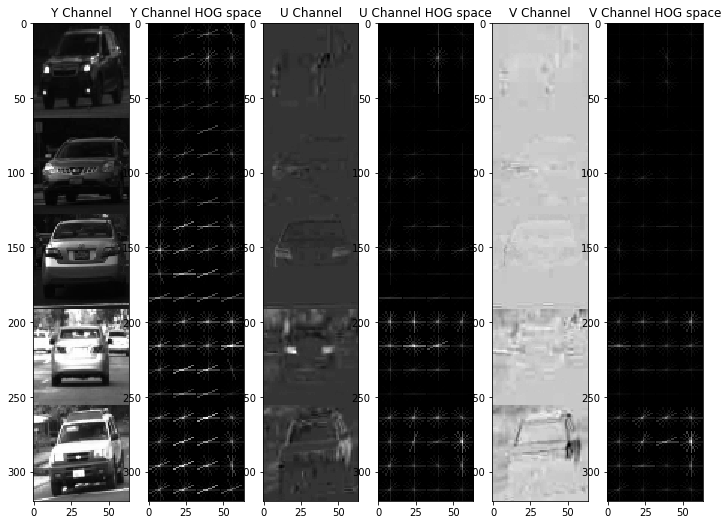

In [6]:
yuv = [cv2.cvtColor(img, cv2.COLOR_BGR2YUV) for img in noccluded_cars_gen.next()]
y = [cv2.split(img)[0] for img in yuv]
u = [cv2.split(img)[1] for img in yuv]
v = [cv2.split(img)[2] for img in yuv]
y_hog = [get_hog_features(img, vis=True)[1] for img in y]
u_hog = [get_hog_features(img, vis=True)[1] for img in u]
v_hog = [get_hog_features(img, vis=True)[1] for img in v]

plt.subplot2grid((1,6), (0,0))
plt.imshow(np.vstack(y), cmap='gray')
plt.title('Y Channel')

plt.subplot2grid((1,6), (0,1))
plt.imshow(np.vstack(y_hog), cmap='gray')
plt.title('Y Channel HOG space')

plt.subplot2grid((1,6), (0,2))
plt.imshow(np.vstack(u), cmap='gray')
plt.title('U Channel')

plt.subplot2grid((1,6), (0,3))
plt.imshow(np.vstack(u_hog), cmap='gray')
plt.title('U Channel HOG space')

plt.subplot2grid((1,6), (0,4))
plt.imshow(np.vstack(v), cmap='gray')
plt.title('V Channel')

plt.subplot2grid((1,6), (0,5))
plt.imshow(np.vstack(v_hog), cmap='gray')
plt.title('V Channel HOG space')

In [7]:
def feature_gen(imgen_num, sp_feat=False, h_feat=False):
    """Batch Feature extractor
    
    Parameters
    ----------
    imgen : generator object
        Image generator object
    num : int
        Required number of features
    sp_feat : boolean (default False)
    h_feat : boolean (default False)
    """
    output = []
    imgen, num = imgen_num
    while len(output) < num:
        img_batch = imgen.next()
        for img in img_batch:
            output.append(extract_features(img,sp_feat=sp_feat, h_feat=h_feat))
            if len(output) > num:
                break
    return output[:num]

from multiprocessing.pool import ThreadPool

def parallel_data_generation(generators):
    """Run feature extraction in parallel to speed it up"""
    
    pool = ThreadPool(processes=len(generators))
    # Block until all processes are done
    start_pool_time = time.time()
    try:
        map_result = pool.map_async(feature_gen, generators)
        while not map_result.ready():
            pass
    except (RuntimeError, KeyboardInterrupt) as e:
        print(e)
    else:
        output_list = map_result.get()
        
    output_list = np.array(output_list).reshape((-1, len(output_list[0][0])))

    pool.close()
    pool.join()
    pool_time = time.time() - start_pool_time
    
    return output_list, pool_time

# Generate Training Data

Training data was generated from all datasets available (Udacity, Kitti and GTI). Also, the udacity set had a further dimension in the data for occluded and non-occluded vehicle images. The total amount of images to train on can be seen in the table below.

|   |   |   |
|---|---|---|
|source | car images | non-car images|
|Udacity | 2000| 6000|
|Udacity occluded | 6000| NA|
|Kitti | 2000 | 5000 |
|GTI | 2000 | 5000 |
|---|---|---|
|total | 12000 | 15000|


In [8]:
# Create Image Generators
start_data_generation_time = time.time()

GENERATOR_COUNT = 1

non_car_gen = gen_non_car_data('object-dataset/', pedestrians, num=GENERATOR_COUNT)
occluded_cars_gen = gen_car_data('object-dataset/', occluded, num=GENERATOR_COUNT)
noccluded_cars_gen = gen_car_data('object-dataset/', noccluded, num=GENERATOR_COUNT)

kitti_cars_path = glob.glob('vehicles/KITTI_extracted/*.png')
gti_cars_path = kitti_path = glob.glob('vehicles/GTI*/*.png')
kitti_gen = gen_from_file_system(kitti_cars_path,num=GENERATOR_COUNT)
gti_gen = gen_from_file_system(gti_cars_path,num=GENERATOR_COUNT)

kitti_noncars_path = glob.glob('non-vehicles/Extras/*.png')
gti_noncars_path = kitti_path = glob.glob('non-vehicles/GTI/*.png')
kitti_noncar = gen_from_file_system(kitti_noncars_path,num=GENERATOR_COUNT)
gti_noncar = gen_from_file_system(gti_noncars_path,num=GENERATOR_COUNT)

OCCLUDED_CARS_PER_SET = 6000
car_generators = [
    (occluded_cars_gen, OCCLUDED_CARS_PER_SET),
]

occluded_car_features, eval_time = parallel_data_generation(car_generators)
print("{num} Occluded car features generated in {t} seconds".format(num=len(occluded_car_features), t = eval_time))


CARS_PER_SET = 2000
car_generators = [
    (kitti_gen, CARS_PER_SET),
    (gti_gen, CARS_PER_SET),
    (noccluded_cars_gen, CARS_PER_SET),
]

car_features, eval_time = parallel_data_generation(car_generators)
print("{num} car features generated in {t} seconds".format(num=len(car_features), t = eval_time))

NONCARS_PER_SET = 5000
noncar_generators = [
    (non_car_gen, NONCARS_PER_SET),
    (kitti_noncar, NONCARS_PER_SET),
    (gti_noncar, NONCARS_PER_SET),
]

noncar_features, eval_time = parallel_data_generation(noncar_generators)
print("{num} noncar features generated in {t} seconds".format(num=len(noncar_features), t = eval_time))

t0 = time.time()
X = np.vstack((car_features, occluded_car_features, noncar_features)).astype(np.float64)   
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print("Scaler generated in {0}s".format(time.time() - t0))

# Define the labels vector
y = np.hstack((np.ones(len(car_features) + len(occluded_car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("Complete training data generated in in {0}s".format(time.time() - start_data_generation_time))
print('Feature vector length:{}'.format(len(X_train[0])))

6000 Occluded car features generated in 310.666612148 seconds
6000 car features generated in 85.032006979 seconds
15000 noncar features generated in 54.577190876 seconds
Scaler generated in 0.178181171417s
Complete training data generated in in 450.51838994s
Feature vector length:256


## Training the classifier

The classifier chosen for the task is SVM. A randomized search for 8 iterations was executed for hyperparamer tuning and a relatively high *C* value of 10 was found as best for classification. The default *gamma* parameter was used.

A subset of 12,000 car images, combined from all datasets, and 15,000 non-car images was employed for classifier training.

The class imbalance was found to improve training and testing results, since non-car images can take any shape, color and form.

Accuracy of the trained classiffier is around 97%.

In [9]:
C_range = np.logspace(0.1, 1, 13)
param_grid = dict(C=C_range)

start_time = time.time()
random_search = RandomizedSearchCV(SVC(), param_distributions=param_grid, n_iter=8, n_jobs=-1)
random_search.fit(X_train, y_train)
print("RandomSEARCH: best parameters are %s with a score of %0.2f"
      % (random_search.best_params_, random_search.best_score_))
print("Evaluation time: {}".format(time.time() - start_time))

RandomSEARCH: best parameters are {'C': 10.0} with a score of 0.96
Evaluation time: 487.015970945


In [11]:
# Based on the random search above, a higher C value results in higher confidence
svc = SVC(C=10)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
print("Evaluation time: {}".format(time.time() - t))
# save model

('Test Accuracy of SVC = ', 0.9698)
Evaluation time: 71.4451110363


In [12]:
# Save the model and training data for further usage
model = {
    'model': svc,
    'scaler': X_scaler,
}

train_data = {
  'train_test': (X_train, X_test, y_train, y_test),
}

pickle.dump(model, open('runs/svc_uv.pickle', 'w'))
# pickle.dump(train_data, open('runs/train_data_uv.pickle', 'w'))

# Load Model

In [197]:
data = pickle.load(open('runs/svc_uv.pickle', 'r'))
svc = data['model']
# (X_train, X_test, y_train, y_test) = data['train_test']
X_scaler = data['scaler']

In [13]:

def predict_on_image(img, svc, scaler):
    """
    2.22 ms per loop
    """
    vec = extract_features(img,sp_feat=False, h_feat=False)
    vec = X_scaler.transform(vec.reshape(1, -1))
    res = svc.predict(vec)
    return True if res[0] else False

## Example Predictions

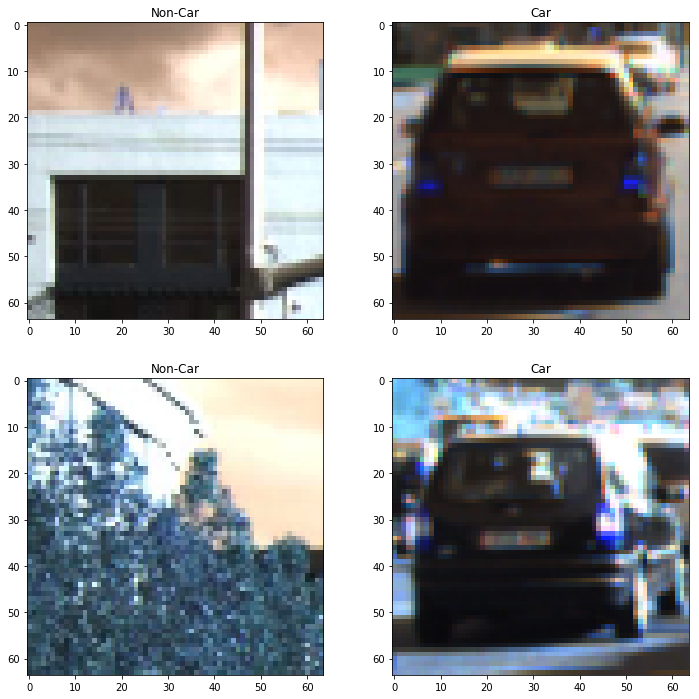

In [14]:
plt.subplot2grid((2,2), (0,0))
img = non_car_gen.next()[0]
plt.imshow(img)
_str = "Car" if predict_on_image(img, svc, X_scaler) else "Non-Car"
plt.title(_str)

plt.subplot2grid((2,2), (0,1))
img = kitti_gen.next()[0]
plt.imshow(img)
_str = "Car" if predict_on_image(img, svc, X_scaler) else "Non-Car"
plt.title(_str)

plt.subplot2grid((2,2), (1,0))
img = non_car_gen.next()[0]
plt.imshow(img)
_str = "Car" if predict_on_image(img, svc, X_scaler) else "Non-Car"
plt.title(_str)

plt.subplot2grid((2,2), (1,1))
img = kitti_gen.next()[0]
plt.imshow(img)
_str = "Car" if predict_on_image(img, svc, X_scaler) else "Non-Car"
plt.title(_str)

## Car Detection - Sliding Windows

A parametric sliding window approach was employed to scan the image for car detection. Several scales for the windows were used, each at specific x-y limit bounds and overlaps. The window scales were chosen based on experiment. The chosen windows sizes were 76px, 94px, 128px and 160px. The total number of windows that needed to be proccessed amounted to 274. One classification is performed in approximately ~3.0 ms, which results in approximately ~.850 seconds for a complete image search.

In [15]:
test_car = noccluded_cars_gen.next()[0]
%timeit predict_on_image(test_car, svc, X_scaler)

100 loops, best of 3: 3.29 ms per loop


In [16]:
def slide_window(img, xlim=(0.05, 0.95), ylim=(0.42, 0.90), xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    resized = cv2.resize(img, (1280, 720))
    ylim = (np.array(ylim) * resized.shape[0]).astype(np.int)
    xlim = (np.array(xlim) * resized.shape[1]).astype(np.int)
    
    # Compute the span of the region to be searched    
    xspan = xlim[1] - xlim[0]
    yspan = ylim[1] - ylim[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + xlim[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + ylim[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
        

def get_windows(windows_config_dict):
    windows = []
    for w in windows_config_dict:
        windows.extend(
            slide_window(
                img, 
                xlim=w['xlim'], 
                ylim=w['ylim'], 
                xy_window=w['window'], 
                xy_overlap=w['overlap']
            )
        )
    return windows

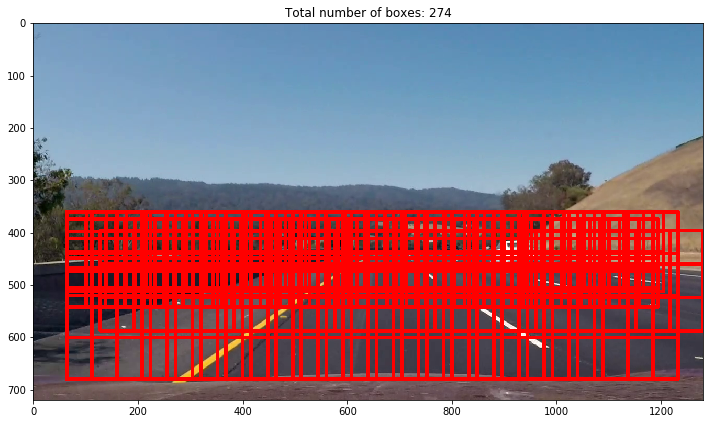

In [23]:
windows_config = [
    {
        "desc": "Fine",
        "xlim": [0.05, 0.95],
        "ylim": [0.5, 0.72],
        "window": [76, 76],
        "overlap": [0.5,0.5]
    },
    {
        "desc": "Medium",
        "xlim": [0.05, .95],
        "ylim": [0.52, 0.76],
        "window": [94, 94],
        "overlap": [0.6,0.6]
    },
    {
        "desc": "Medium",
        "xlim": [0.1, 1],
        "ylim": [0.55, 0.85],
        "window": [128, 128],
        "overlap": [0.5,0.5]
    },
    {
        "desc": "Coarse",
        "xlim": [0.05, 0.999],
        "ylim": [0.5, 0.98],
        "window": [160, 160],
        "overlap": [0.7, 0.5]
    }
]

cap = cv2.VideoCapture('project_video.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 640 + np.random.randint(0,20,1)[0])
ret, img = cap.read()
windows = get_windows(windows_config)
img_with_boxes = draw_boxes(img.copy(), windows)
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("Total number of boxes: {}".format(len(windows)))
# cap.release()



### Parallel Window Search

Python's multiprocessing module was employed to parallelize the sliding window search, by breacking the windows into batches and sending the sliding window search to be executed on these batches in parallel.

In [24]:
   
def slide_through_image((img, windows)):
    good_windows = []
#     heatmap = np.zeros_like(img)
    for window in windows:
        (x1,y1), (x2,y2) = window
        roi = img[y1:y2,x1:x2]
        roi = cv2.resize(roi, (64,64))
        if predict_on_image(roi, svc, X_scaler):
            good_windows.append(window)
#             heatmap[y1:y2,x1:x2,1] += 1
            
#     if candidate_detection:
#         heatmap = heatmap.astype(np.float32)/heatmap.max()
#         heatmap *= 255
#         heatmap = heatmap.astype(np.uint8)
    return good_windows

from multiprocessing.pool import Pool

def parallel_slide_through_image(img, windows, batch_size=25):
    n = batch_size
    window_lists = [(img,windows[i:i + n]) for i in range(0, len(windows), n)]
    
    pool = ThreadPool(processes=len(window_lists))
    # Block until all processes are done
    start_pool_time = time.time()
    try:
        map_result = pool.map_async(slide_through_image, window_lists)
        while not map_result.ready():
            pass
    except (RuntimeError, KeyboardInterrupt) as e:
        print(e)
    else:
        output_list = map_result.get()
        
#     output_list = np.array(output_list).reshape((-1, len(output_list[0][0])))

    pool.close()
    pool.join()
    pool_time = time.time() - start_pool_time
    output_list = [y for x in output_list if len(x) > 0 for y in x]
    return  output_list

In [25]:
%timeit slide_through_image((img, windows))

1 loop, best of 3: 866 ms per loop


In [26]:
%timeit parallel_slide_through_image(img, windows)

1 loop, best of 3: 505 ms per loop


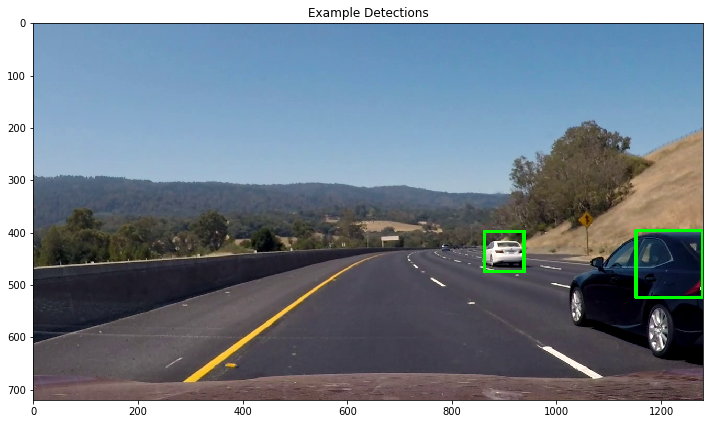

In [27]:
cap = cv2.VideoCapture('project_video.mp4')
# frame = 600 + np.random.randint(0,40,1)[0]
frame = 713
cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
# cap.set(cv2.CAP_PROP_POS_FRAMES, 574)
ret, img = cap.read()
# 
good_windows = parallel_slide_through_image(img, windows)
img = draw_boxes(img, good_windows, color=(0,255,0))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Example Detections")

## Centroid clustering with DBSCAN

The sliding window approach results, in most cases, in several overlapping windows at varying scales with positive detections and occasional false-positives scatterred throughout the image. For this assignment a clustering approach was seen valid and the DBSCAN algorithm was employed for that purpose, where centroids lying a predefined distance from each other are gathered, their mean area infered and their mean position identified.

In [28]:
from sklearn.cluster import DBSCAN

def get_centres(good_windows):
    centres = []
    areas = []
    for window in good_windows:
        (x0, y0), (x1, y1) = window
        width, height = (x1 - x0), (y1 - y0)
        centre = x0 + np.int(0.5 * width), y0 + np.int(0.5 * height)
        areas.append(width * height)
        centres.append(centre)
    return np.array(centres), np.array(areas)

def cluster_points(centres, areas, eps=0.2, min_samples=2):
    # Create a copy of the centres and normalize them
    centres = np.array(centres)
    areas = np.array(areas)
    if len(centres) < 2:
        return [{
            "label": -1,
            "centre": centres.squeeze(),
            "area": areas.squeeze(),
        }]
    
    norm_coeffs = np.array(centres).astype(np.float)
    norm_coeffs /= norm_coeffs.max(axis=0)
#     numpy.logical_not(numpy.isnan(x))
    # Cluster closely matching points
    db = DBSCAN(
        eps=eps,
        min_samples=min_samples,
    ).fit(norm_coeffs)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    output = []
    # Average out lines in the found clusters
    for k in set(labels):
        if not k == -1:
            class_member_mask = (labels == k)
            indxs = class_member_mask & core_samples_mask
            xy_, ar_ = centres[indxs], areas[indxs]
            xy_, ar_ = np.mean(xy_, 0).astype(np.int), np.mean(ar_, 0).astype(np.int)
            s = np.sqrt(ar_)
            output.append({
                'label': k,
                'centre':xy_,
                'area':ar_,
#                 'box': ((int(xy_[0]-s), int(xy_[1]-s)), (int(xy_[0]+s), int(xy_[1]+s)))
            })  
    return output

def show_centres(img, output, r=10, eps=0.2, min_samples=3):
    imgcp = img.copy()
   
    for doc in output:
        centre = tuple(doc['centre'].tolist())
        radius = np.int(np.sqrt(doc['area'] / np.pi))
        side = np.int(np.sqrt(doc['area']))
#         imgcp = draw_boxes(imgcp,  (pt0, pt1), color=(0,255,0))
        cv2.circle(imgcp, centre, r, (0,255,0), -1 )
        cv2.circle(imgcp, centre, radius, (0,255,255), 5 )
    return imgcp

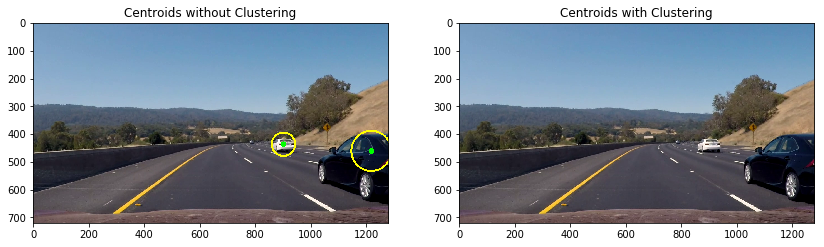

In [29]:
plt.rcParams['figure.figsize'] = 14,14
cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
ret, img = cap.read()
good_windows = parallel_slide_through_image(img, windows)
centres, areas = get_centres(good_windows)
if len(centres) > 0:
    output1 = cluster_points(centres, areas, eps=0.01, min_samples=1)
    output2 = cluster_points(centres, areas, eps=0.1, min_samples=2)
    img1 = show_centres(img, output1)
    img2 = show_centres(img, output2)
plt.subplot2grid((1,2), (0,0))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.title('Centroids without Clustering')
plt.subplot2grid((1,2), (0,1))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.title('Centroids with Clustering')

In [30]:
def catch_user_interrupt(wait_time=1):
    """
    OpenCV specific high-gui window interruption handler
    """
    ch = 0xFF & cv2.waitKey(wait_time)
    return True if ch == 27 else False

def draw_str(img, (x, y), s, scale=0.3):

    cv2.putText(img, s, (x, y), cv2.FONT_HERSHEY_PLAIN, scale, (255, 255, 255),
                lineType=cv2.LINE_AA)
    cv2.putText(img, s, (x+1, y+1), cv2.FONT_HERSHEY_PLAIN, scale, (0, 0, 0),
                thickness=1, lineType=cv2.LINE_AA)

## False Positive Reduction

Although the algorithm seemed very robust, false-positives made their way through the pipeline. In order to reduce them a two-layer clustering was implemented with an active queue. The first level clustering was performed on the candidate windows detected. On the second level, the results of the first level are clustered together with the Queue, holding old detections. The new results are appended to the queue and drawn to the output image. Finally, the infered mean rectangle around a car was being fed to the classifier and if successfull, it was added to the queue for enhancing the next detections (momentum).

In [33]:
# Add here the paths to the videos you wish to analyze
titles = [
    'project_video.mp4',
]
# 
fourcc = cv2.VideoWriter_fourcc(*'XVID')
for title in titles:
    
    cap = cv2.VideoCapture(title)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    
    writer = cv2.VideoWriter(
        os.path.join('results',"result_" + title),
        fourcc,
        cap.get(cv2.CAP_PROP_FPS),
        (
            int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
            int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        )
    )

    centres, areas = [],[]
    last_frames_queue = []
    Q_MAXSIZE = 25
    level_one_clustering = []
    level_two_clustering = []
    l2_windows = []
    
    while True:
        ret, img = cap.read()
        good_windows = []
        if not ret:
            break
        good_windows = parallel_slide_through_image(img, windows)
        if len(l2_windows) > 0:
            # Get the bounding box of good previous detections
            good_windows.extend(l2_windows)
            
        old_centres, old_areas = centres, areas
        l1_centres, l1_areas = get_centres(good_windows)
        draw_img = img.copy()
#         draw_img = draw_boxes(img.copy(), good_windows, color=(0,255,0))
        num = 0
    
#         if len(CARS) < 1:
#             initial_detections = [0]
#         else:
#             initial_detections = [x['detections'] for x in CARS]
#         while len(last_frames_queue) >= Q_MAXSIZE:
#             last_frames_queue.pop(0)
            
        if len(l1_centres) > 0:
            level_one_clustering = cluster_points(l1_centres, l1_areas, eps=0.06, min_samples=2)
            if len(level_one_clustering) > 0:
                for cluster in level_one_clustering:
                    last_frames_queue.append([cluster])
                    if len(last_frames_queue) >= Q_MAXSIZE:
                        last_frames_queue.pop(0)
        else:
            level_one_clustering = None
            if len(last_frames_queue) > 0:
                last_frames_queue.pop(0)

        l2_centres = []
        l2_areas = []
        for frameobj in last_frames_queue:
            centres_ = [item['centre'] for item in frameobj]                    
            areas_ = [item['area'] for item in frameobj]
            if len(areas_) > 0 and len(centres_) > 0:
                l2_centres.extend(centres_)
                l2_areas.extend(areas_)

        l2_centres, l2_areas = np.array(l2_centres), np.array(l2_areas)

        if len(l2_areas) > 1 or len(l2_centres) > 1:
            level_two_clustering = cluster_points(l2_centres, l2_areas, eps=0.1, min_samples=8)           
        else:
            level_two_clustering = []

#         if len(l2_centres) > 0 and len(l2_areas) > 0:
#             CARS = add_remove_cars(CARS, level_two_clustering)
#         else:
#             level_one_clustering = None
#             level_two_clustering = None

#         CARS = clean_up_cars(CARS, initial_detections)
#         plot_obj = get_car_plot_obj(CARS)
        l2_windows = []
        candidate_cars = []
        if len(level_two_clustering) > 0:
            for cluster in level_two_clustering:
                side = np.int(np.sqrt(cluster['area']))
                x1,y1 = cluster['centre'] - side / 2
                x2,y2 = cluster['centre'] + side / 2
                # Test if a car can be detected in this area
                roi = cv2.resize(img[y1:y2,x1:x2], (64,64))
                candidate_car = ((x1,y1), (x2,y2))
                candidate_cars.append(candidate_car)
                if predict_on_image(roi, svc, X_scaler):
                    l2_windows.append(candidate_car)
                
            draw_img = draw_boxes(draw_img, candidate_cars, color=(0,255,255))
#             img = show_centres(img, level_two_clustering)

        _str = "Queue Size: {}".format(len(last_frames_queue))
        draw_str(draw_img, (20,20), _str, scale=1.0)
        
        _str = "{num} Candidate Detections".format(num=len(l1_centres))
        draw_str(draw_img, (20,40), _str, scale=1.0)
        
        _str = "{num} Cars found".format(num=len(level_two_clustering))
        draw_str(draw_img, (20,60), _str, scale=1.0)
        
        _str = "Frame: {}".format(cap.get(cv2.CAP_PROP_POS_FRAMES))
        draw_str(draw_img, (20,80), _str, scale=1.0)
        
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        writer.write(draw_img)
        cv2.imshow('video', draw_img)
        
       
        if catch_user_interrupt():
            break
    writer.release()
    cap.release()
    cv2.destroyAllWindows()

## Results

In [34]:
from IPython.display import HTML

# Youtube
HTML('<div style="position:relative;height:0;padding-bottom:56.25%"><iframe src="https://www.youtube.com/embed/8AF0qx92WiM?ecver=2" width="640" height="360" frameborder="0" style="position:absolute;width:100%;height:100%;left:0" allowfullscreen></iframe></div>')

## Discussion and Conclusions

As is visible from the video, detection and tracking works smoothly for the larger part of the video, however, some false-positives at the start make it through. Also, when cars approach edges, the detection and tracking start to fail since at the edges the window density is less to none. These misses and false-positives could be reduced with a larger training set as well as a smart(er) prediction window setting.

The performance of the during training and execution was greatly improved through python generators and multiprocessing. The final pipeline operated on just more than two Hertz (>2Hz) on a machine with an I7 processor.

The DBSCAN based clustering proved itself well performing.


## Obsoleted Code Below

In [ ]:
# def movav(Q, data, stds=6, axis_thresh=1):
#     """
#     Moving average of a queue with outlier rejection

#     Outliers  lying `stds` standard  deviations away from the mean of the queue
#     are discarded.

#     Parameters
#     ----------
#     Q : Queue.Queue object
#         A Queue object
#     data : ndarray
#         A queue item candidate
#     stds : int
#         Number of standard deviations for rejection threshold
#     axis_thresh : float
#         Threshold for number of correct axes of `data` (within the `stds` standard
#         deviations) in order to at an element to the queue `Q`

#     Returns
#     -------
#     movav : ndarray
#         The average of the filtered queue
#     """
#     if Q.full():
#         Q.get()

#     if len(Q.queue) < (Q.maxsize):
#         Q.put(data)
#     else:
#         current_mean = np.mean(Q.queue, axis=0)
#         current_std = np.std(Q.queue, axis=0)
#         cond = np.abs(data - current_mean) < (stds * current_std)
#         if cond.sum() >= axis_thresh:
#             print("{}: Added new frame".format(time.time()))
#             Q.put(data)
#         else:
#             print("{}:Discarded outlier frame".format(time.time()))

#     return np.mean(Q.queue, axis=0)

In [ ]:
# If single point detection is made within delta (100px) for 3 consequtive frames, a CAR is identified.

In [ ]:
# from moviepy.editor import VideoFileClip
# # import imageio
# # imageio.plugins.ffmpeg.download()
# def apply_threshold(heatmap, threshold):
#     # Zero out pixels below the threshold
#     heatmap[heatmap <= threshold] = 0
#     # Return thresholded map
#     return heatmap

# def process_image(img):
#     good_windows = slide_through_image(img, windows)
#     centres, areas = get_centres(good_windows)
#     if len(centres) > 0:
#         output = cluster_points(centres, areas, eps=0.1, min_samples=1)
#         img = show_centres(img, output)
#     return img

# def process_video (input_path, output_path):
#     clip = VideoFileClip (input_path)
#     result = clip.fl_image (process_image)
#     %time result.write_videofile (output_path)

# # select video to operate on
# # process_video ('test_video.mp4', 'test_video_result.mp4')
# process_video ('project_video.mp4', 'results/project_video_result.mp4')
# process_video ('challenge_video.mp4', 'results/challenge_video_result.mp4')
# process_video ('harder_challenge_video.mp4', 'results/harder_challenge_video_result.mp4')

In [166]:
def candidate_in_car(candidate, car):
    if len(car['centres']) > 1:
        mean_car = np.mean(car['centres'], axis=0)
        mean_areas = np.mean(car['areas'], axis=0)
    else:
        mean_car = np.array(car['centres'])
        mean_areas = np.array(car['areas'])

    mean_candidate_centre = np.mean(candidate['centre'], axis=0)
    mean_candidate_area = np.mean(candidate['area'], axis=0)
    
    diff = mean_car - mean_candidate_centre
    dist = np.sqrt(np.square(diff).sum())
    radius_car = np.sqrt( mean_areas/ np.pi)
    radius_candidate = np.sqrt(mean_candidate_area / np.pi)
    if dist < (radius_car + radius_candidate):
        if len(car['centres']) >= 10:
            car['centres'].pop(0)
            car['areas'].pop(0)
#                     car['centres'].append(np.array((mean_car + mean_candidate)/2.0, np.int).squeeze())
        car['centres'].append(np.array(mean_candidate, np.int).squeeze())
        car['areas'].append(np.array((mean_areas + candidate['area'])/2.0, np.int).squeeze())
        car['detections'] += 1
        return car
    else:
        return None

def add_remove_cars(cars, level_two_clustering):
    
    if level_two_clustering is None:
        return cars

    new_candidates = []
    for candidate in level_two_clustering:
        car = None
        if len(cars) < 1:
            car = {
                "centres": [candidate['centre']],
                "areas": [candidate['area']],
                "detections": 1
            }
            cars.append(car)
        else:
            for indx, _car in enumerate(cars):
                car = candidate_in_car(candidate, _car)
                if car is None:
                    car = {
                        "centres": [candidate['centre']],
                        "areas": [candidate['area']],
                        "detections": 1
                    }
                    cars.append(car)
#                     print "No match found. Appending new car"
#                     new_candidates = add_remove_cars(new_candidates, [candidate])
                else:
                    cars[indx] = car    
    return cars

def get_car_plot_obj(cars, min_detections=6):
    plot_object = []
    if cars is None:
        return []
    for car in cars:
        if car['detections'] >= min_detections:
            plot_object.append({
#              'centre': np.array(car['centres'][-1], np.int).squeeze(),
             'centre': np.mean(car['centres'], axis=0).astype(np.int),
             'area': np.mean(car['areas'], axis=0).astype(np.int),
            })
    return plot_object

def clean_up_cars(cars, initial_detections):
    for indx,(car, detection) in enumerate(zip(cars, initial_detections)):
        if car['detections'] == detection:
            car['centres'].pop(0)
            car['areas'].pop(0)
            car['detections'] -= 1
            cars[indx] = car
        if len(car['centres']) < 1:
            cars.pop(indx)
    return cars

def safeput(Q, data, stds=6, axis_thresh=1):
    if Q.full():
        Q.get()
    if len(Q.queue) < (Q.maxsize):
        Q.put(data)
    return Q
